<a href="https://colab.research.google.com/github/ayuksekdag/winacademy_python_dna/blob/main/final_assignment/final_co2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

todo:
opnemen als dataset
https://ourworldindata.org/grapher/registered-vehicles-per-1000-people
> Ingesprongen blok



#Assignment / Questions

- What is the biggest predictor of a large CO2 output per capita of a country?
- Which countries are making the biggest strides in decreasing CO2 output?
- Which non-fossil fuel energy technology will have the best price in the future?

Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors. Anyway, remember to include the explanations in your report.


Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


Best future price for non-fossil fuel energy

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b


# Scope of sources

- source 1: https://ourworldindata.org/population-growth
  - filename:population-and-demography.csv
  - alias: pop_ann_raw

- source 2: https://ourworldindata.org/co2-emissions
  - filename: annual-co2-emissions-per-country.csv
  - alias: c02_ann_raw

- source 3: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?most_recent_value_desc=true
  - filename: gdp-per-capita-worldbank.csv
  - alias: gdp_cap_raw

- source 4: https://ourworldindata.org/grapher/meat-consumption-vs-gdp-per-capita
  - filename: meat-consumption-vs-gdp-per-capita.csv
  - alias: meat_cap_raw

- source 5: https://ourworldindata.org/grapher/levelized-cost-of-energy
  - filename: levelized-cost-of-energy.csv
  - alias: cost_engy_raw

- source 6: https://ourworldindata.org/grapher/registered-vehicles-per-1000-people
  - filename: registered-vehicles-per-1000-people.csv
  - alias: vehicle_raw

- source 7: https://ourworldindata.org/grapher/share-healthy-diet-unaffordable
  - filename: share-healthy-diet-unaffordable.csv
  - alias: healty_diet_raw

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
#sources
pop_ann_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/population-and-demography.csv')
c02_ann_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/annual-co2-emissions-per-country.csv')
gdp_cap_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/gdp-per-capita-worldbank.csv')
meat_cap_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/meat-consumption-vs-gdp-per-capita.csv' )
cost_engy_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/levelized-cost-of-energy.csv')
vehicle_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/registered-vehicles-per-1000-people.csv')
healty_diet_raw = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/share-healthy-diet-unaffordable.csv')

# Data preparation
step 1. create copy dataframe from raw

step 2. Renaming columns

step 3. Data conversions
  - year column to date
  - int for measures

step 4. Cleaning of data.
  - Goal: All datasets must have same countries and same selection of years
  - 1. Filter: Remove non countries entries
  - 2.  Take a inner join (intersection) of all datasets on country and year of the measure.


In [3]:
# step 1
# remove column or select only columns needed and put them in a new dataframe
pop_ann_prep = pop_ann_raw[['Country name','Year','Population']].copy()
c02_ann_prep = c02_ann_raw[['Entity','Year','Annual CO₂ emissions']].copy()
gdp_cap_prep = gdp_cap_raw[['Entity','Year','GDP per capita, PPP (constant 2017 international $)']].copy()
meat_cap_prep = meat_cap_raw[['Entity','Year','Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita']].copy()
vehicle_prep = vehicle_raw[['Entity','Year','Registered vehicles per 1,000 people']].copy()
healty_diet_prep = healty_diet_raw[['Entity','Year','Share of the population who cannot afford a healthy diet']].copy()

In [4]:
# step2
#rename long column names with spaces and special characters
pop_ann_prep.rename(columns={'Country name': 'Country', 'Population': 'Country_population' }, inplace=True)
c02_ann_prep.rename(columns={'Entity': 'Country', 'Annual CO₂ emissions': 'Country_Annual_c02'}, inplace=True)
gdp_cap_prep.rename(columns={'Entity': 'Country','GDP per capita, PPP (constant 2017 international $)': 'Annual_gdp_per_cap'}, inplace=True)
meat_cap_prep.rename(columns={'Entity': 'Country','Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita': 'Annual_meat_per_cap'}, inplace=True)
vehicle_prep.rename(columns={'Entity': 'Country','Registered vehicles per 1,000 people': 'number_of_vehicles_per_1000_people'}, inplace=True)
healty_diet_prep.rename(columns={'Entity': 'Country','Share of the population who cannot afford a healthy diet': 'diet_share'}, inplace=True)

In [5]:
#step 3
#change datatype year to datetime
pop_ann_prep['Year'] = pd.to_datetime(pop_ann_prep['Year'], format='%Y')
c02_ann_prep['Year'] = pd.to_datetime(c02_ann_prep['Year'], format='%Y')
gdp_cap_prep['Year'] = pd.to_datetime(gdp_cap_prep['Year'], format='%Y')
vehicle_prep['Year'] = pd.to_datetime(vehicle_prep['Year'], format='%Y')
healty_diet_prep['Year'] = pd.to_datetime(healty_diet_prep['Year'], format='%Y')
#only meat filled
meat_cap_prep = meat_cap_prep[meat_cap_prep['Annual_meat_per_cap'].notnull()].copy()
#change datatype year to datetime
meat_cap_prep['Year'] = pd.to_datetime(meat_cap_prep['Year'], format='%Y')







#change datatype from float to int
c02_ann_prep['Country_Annual_c02'] = c02_ann_prep['Country_Annual_c02'].astype(int)
gdp_cap_prep['Annual_gdp_per_cap'] = gdp_cap_prep['Annual_gdp_per_cap'].astype(int)
meat_cap_prep['Annual_meat_per_cap'] = meat_cap_prep['Annual_meat_per_cap'].astype(int)
vehicle_prep['number_of_vehicles_per_1000_people'] = vehicle_prep['number_of_vehicles_per_1000_people'].astype(int)
healty_diet_prep['diet_share'] = healty_diet_prep['diet_share'].astype(int)

In [6]:
# # step 4

# meat dataset needs cleaned before joining to avoid cartesian product
print(f' \n grootte pop_ann_prep  {pop_ann_prep.shape}')
print(f' \n grootte c02_ann_prep {c02_ann_prep.shape}')
print(f' \n grootte gdp_cap_prep {gdp_cap_prep.shape}')
print(f' \n grootte meat_cap_prep {meat_cap_prep.shape}')
print(f' \n grootte vehicle_prep {vehicle_prep.shape}')
print(f' \n grootte healty_diet_prep {healty_diet_prep.shape}')

 
 grootte pop_ann_prep  (18288, 3)
 
 grootte c02_ann_prep (31349, 3)
 
 grootte gdp_cap_prep (6346, 3)
 
 grootte meat_cap_prep (12360, 3)
 
 grootte vehicle_prep (161, 3)
 
 grootte healty_diet_prep (763, 3)


In [7]:
# step 4
# INTERSECTION (INNER JOIN) TO CREATE 1 DATASET BASED ON COUNTRY AND YEAR.
# The final result will be clean set of countries having both measures

dataset_key = ['Country','Year']

pop_ann_c02_prep = (
    pd.merge(pop_ann_prep,c02_ann_prep, how="inner", on=dataset_key, suffixes=('', '_y'))
)

pop_ann_c02_gdp_prep = (
    pd.merge(pop_ann_c02_prep ,gdp_cap_prep, how="inner", on=dataset_key, suffixes=('', '_y'))
)

pop_ann_c02_gdp_meat_prep = (
    pd.merge(pop_ann_c02_gdp_prep , meat_cap_prep , how="left", on=dataset_key, suffixes=('', '_y'))
)

pop_ann_c02_gdp_meat_vehicle_prep = (
    pd.merge(pop_ann_c02_gdp_meat_prep , vehicle_prep , how="left", on=dataset_key, suffixes=('', '_y'))
)

pop_ann_c02_gdp_meat_vehicle_diet_prep = (
    pd.merge(pop_ann_c02_gdp_meat_vehicle_prep , healty_diet_prep , how="left", on=dataset_key, suffixes=('', '_y'))
)



#calculate C02 per capita

pop_ann_c02_gdp_meat_vehicle_diet_prep['Annual_c02_per_cap'] = pop_ann_c02_gdp_meat_vehicle_diet_prep['Country_Annual_c02'] / pop_ann_c02_gdp_meat_vehicle_diet_prep['Country_population']
pop_ann_c02_gdp_meat_vehicle_diet_prep['Annual_c02_per_cap'] = pop_ann_c02_gdp_meat_vehicle_diet_prep['Annual_c02_per_cap'].astype(int)


print(f'final dataset structure pop_ann_c02_gdp_meat_vehicle_diet_prep \n\n{pop_ann_c02_gdp_meat_vehicle_diet_prep.dtypes}')

final dataset structure pop_ann_c02_gdp_meat_vehicle_diet_prep 

Country                                       object
Year                                  datetime64[ns]
Country_population                             int64
Country_Annual_c02                             int64
Annual_gdp_per_cap                             int64
Annual_meat_per_cap                          float64
number_of_vehicles_per_1000_people           float64
diet_share                                   float64
Annual_c02_per_cap                             int64
dtype: object


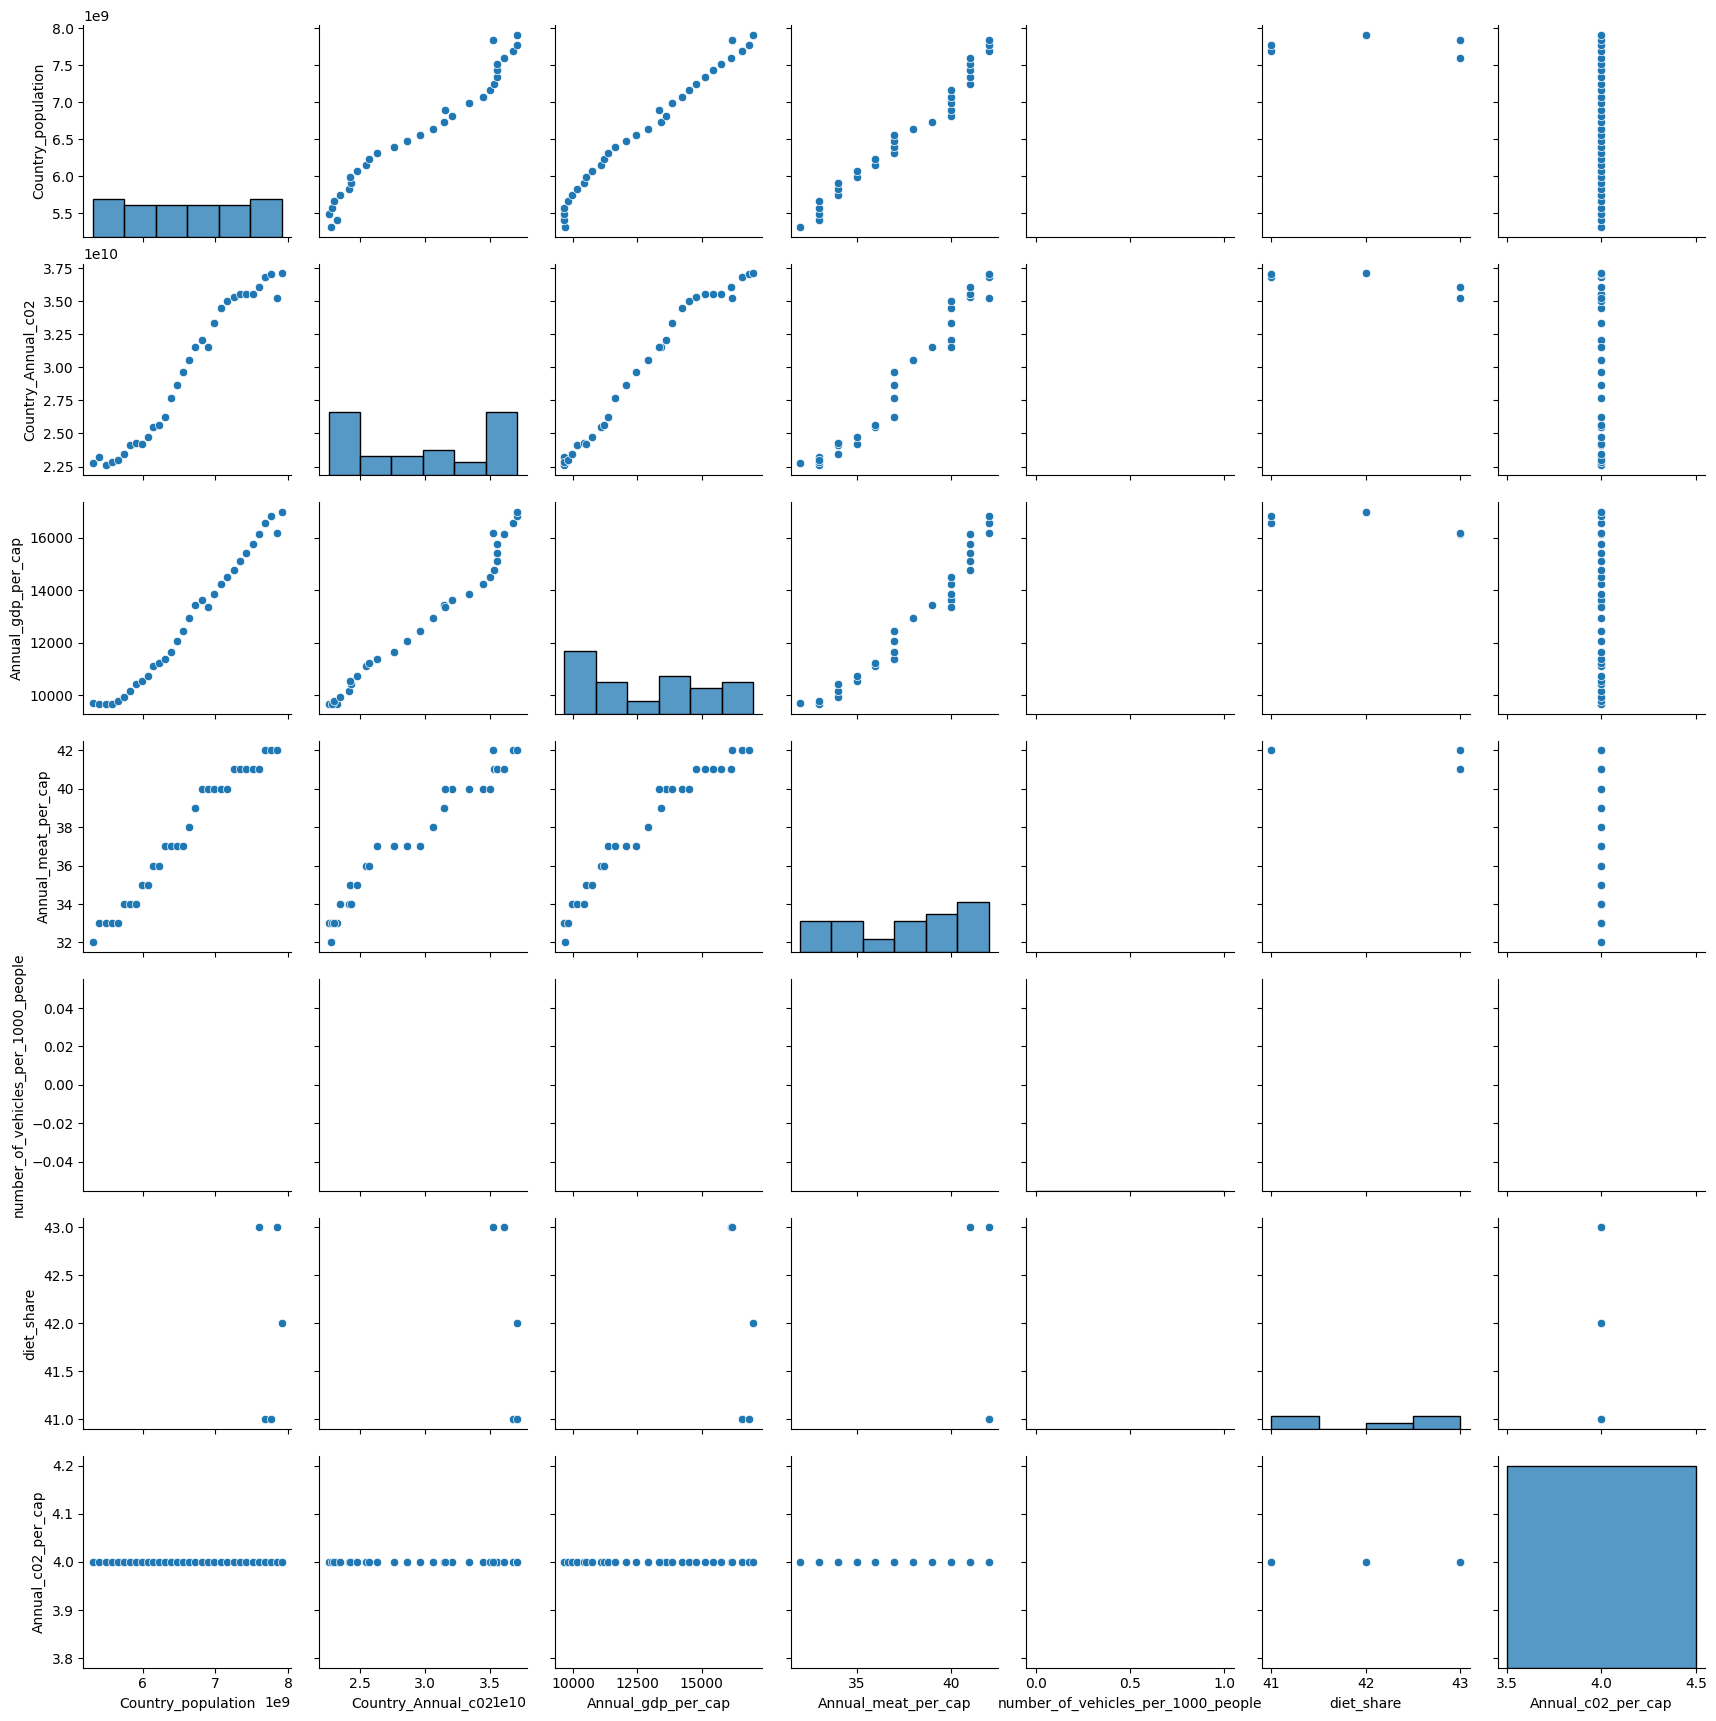

In [8]:
#filter only the world record
# and search for correlation
correlation1_prep = pop_ann_c02_gdp_meat_vehicle_diet_prep[pop_ann_c02_gdp_meat_vehicle_diet_prep['Country'].isin(['World'])].copy()
sns.pairplot(correlation1_prep)


#ASSUMPTION ASSIGNMENT 1
According to the pairplit there is strong correlation between
1. Country population
2. GDP per cap
3. meat per cap on Co2 emmission.

We take 3 countries with large population. 2 Bricks countries: China & India and 2 developed country United States & Germancy to analyze population, GDP and meat consumption and its effect on C02 emission

graph1 C02 per capita vs population growth
graph2 C02 per capita vs GDP per capita
graph3 C02 per capita vs meat per capita




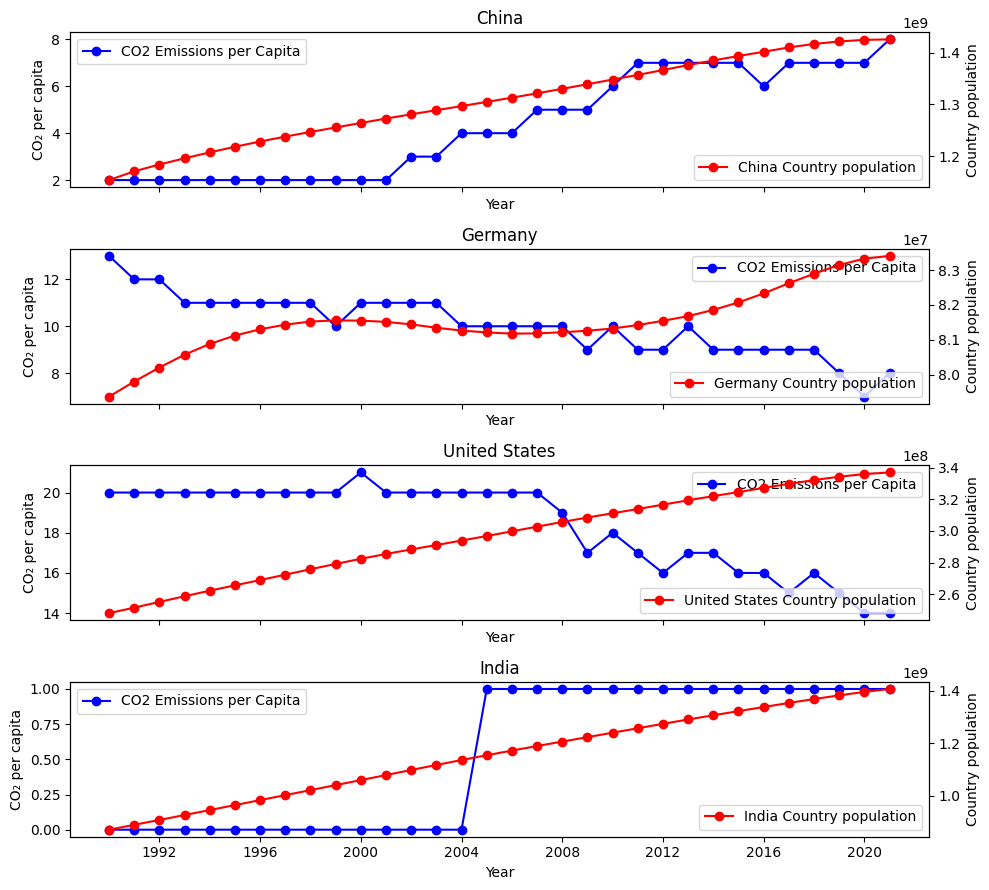

In [9]:
# graph1 C02 per capita vs population growth
#loop for every county

countries_to_plot = {"China", "India", "United States", "Germany"}

fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(10, 9), sharex=True)

c02_color='blue'
pop_color='red'


for i, country in enumerate(countries_to_plot):

  df = pop_ann_c02_gdp_meat_vehicle_diet_prep[pop_ann_c02_gdp_meat_vehicle_diet_prep["Country"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["Annual_c02_per_cap"], label="CO2 Emissions per Capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color='black')
  ax[i].tick_params(axis='y', labelcolor='black')
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure country population growth
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["Country_population"], label=f"{country} Country population", marker='o', color=pop_color)
  ax2.set_ylabel('Country population', color='black')
  ax2.tick_params(axis='y', labelcolor='black')
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()

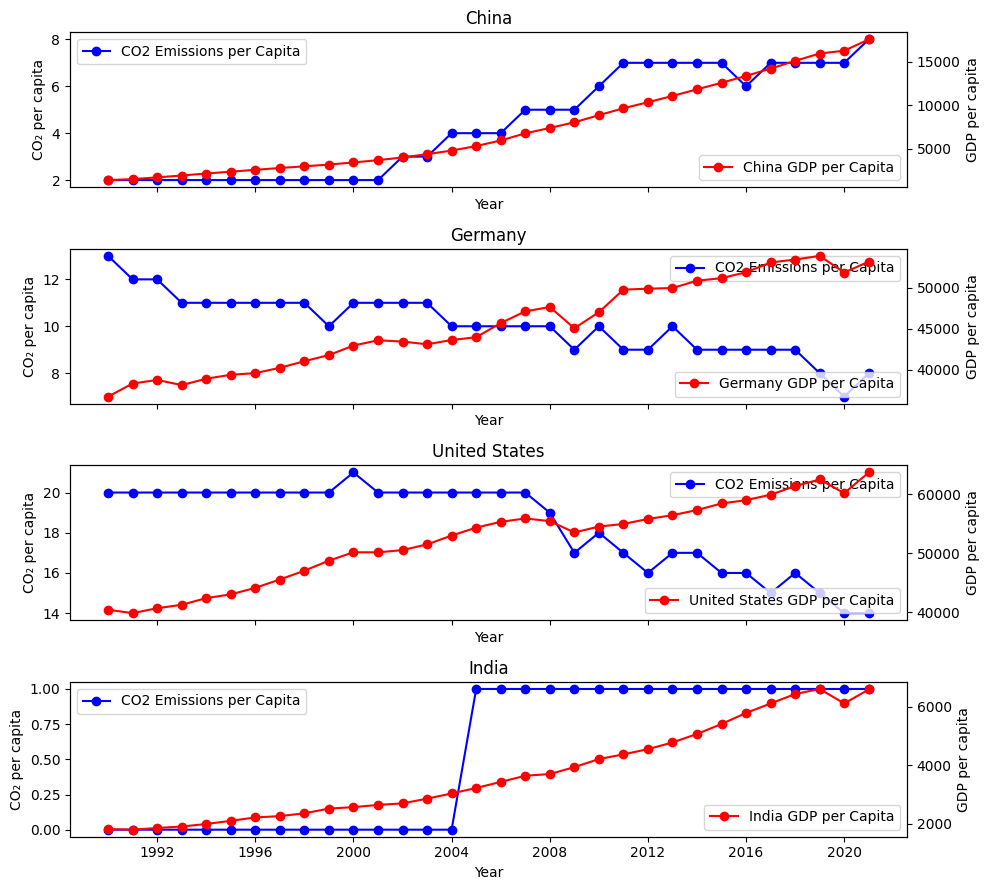

In [15]:
# graph2
# C02 per capita vs GDP per capita

c02_color='blue'
gdp_color='red'

fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(10, 9), sharex=True)

#loop for every county
for i, country in enumerate(countries_to_plot):

  df = pop_ann_c02_gdp_meat_vehicle_diet_prep[pop_ann_c02_gdp_meat_vehicle_diet_prep["Country"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["Annual_c02_per_cap"], label="CO2 Emissions per Capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color='black')
  ax[i].tick_params(axis='y', labelcolor='black')
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure gdp on the right side
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["Annual_gdp_per_cap"], label=f"{country} GDP per Capita", marker='o', color=gdp_color)
  ax2.set_ylabel('GDP per capita', color='black')
  ax2.tick_params(axis='y', labelcolor='black')
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()



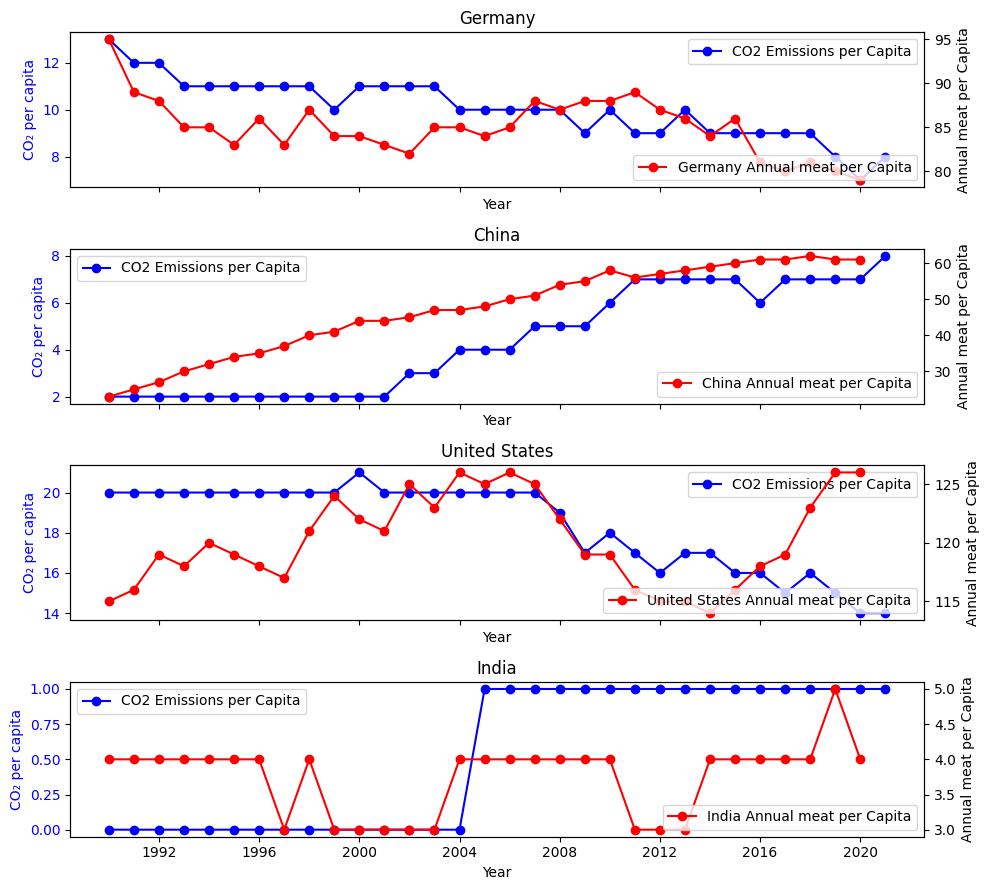

In [16]:
# graph3
# C02 per capita vs Meat consumption per capita

countries_to_plot = {"China", "India", "United States", "Germany"}


c02_color='blue'
gdp_color='red'

fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(10, 9), sharex=True)

#loop for every county
for i, country in enumerate(countries_to_plot):

  df = pop_ann_c02_gdp_meat_vehicle_diet_prep[pop_ann_c02_gdp_meat_vehicle_diet_prep["Country"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["Annual_c02_per_cap"], label="CO2 Emissions per Capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color=c02_color)
  ax[i].tick_params(axis='y', labelcolor=c02_color)
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure gdp on the right side
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["Annual_meat_per_cap"], label=f"{country} Annual meat per Capita", marker='o', color=gdp_color)
  ax2.set_ylabel('Annual meat per Capita', color='black')
  ax2.tick_params(axis='y', labelcolor='black')
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()


### Question 1
- Question: What is the biggest predictor of a large CO2 output per capita of a country?
- Answer/ Conclusion: 1.There is a strong correlation between Country population GDP per cap on Co2 emmission. Although meat comsumption has also impact. This isnt the biggest predictor. In developed countries the correlation on C02 is negative on GDP and in less developed countries like BRICS countries we see possitive correlation.




### Question / Answer 2:
- Question : Which countries are making the biggest strides in decreasing CO2 output?
- Assumption:
  - Step 1:  We first take a year as starting point to calculate from. In this case we take year 2000 as starting point
  - Step 2: We exclude non countries records
  - Step 3: Then we calculate the mean of the gdp per capita for 2001 and forward.
  - Step 4: We look at the difference between 2000 and the mean over 2000>
  The best countries are the ones who score the highest difference between the 2000 - (mean over 2000>)

  formula = 2000 - mean. If negative you are using more c02 per capita. If positive you're decreasing c02 per capita.

We take top 10 highest positive to create a list best striders
UAE is at the top of the list.

Solution below

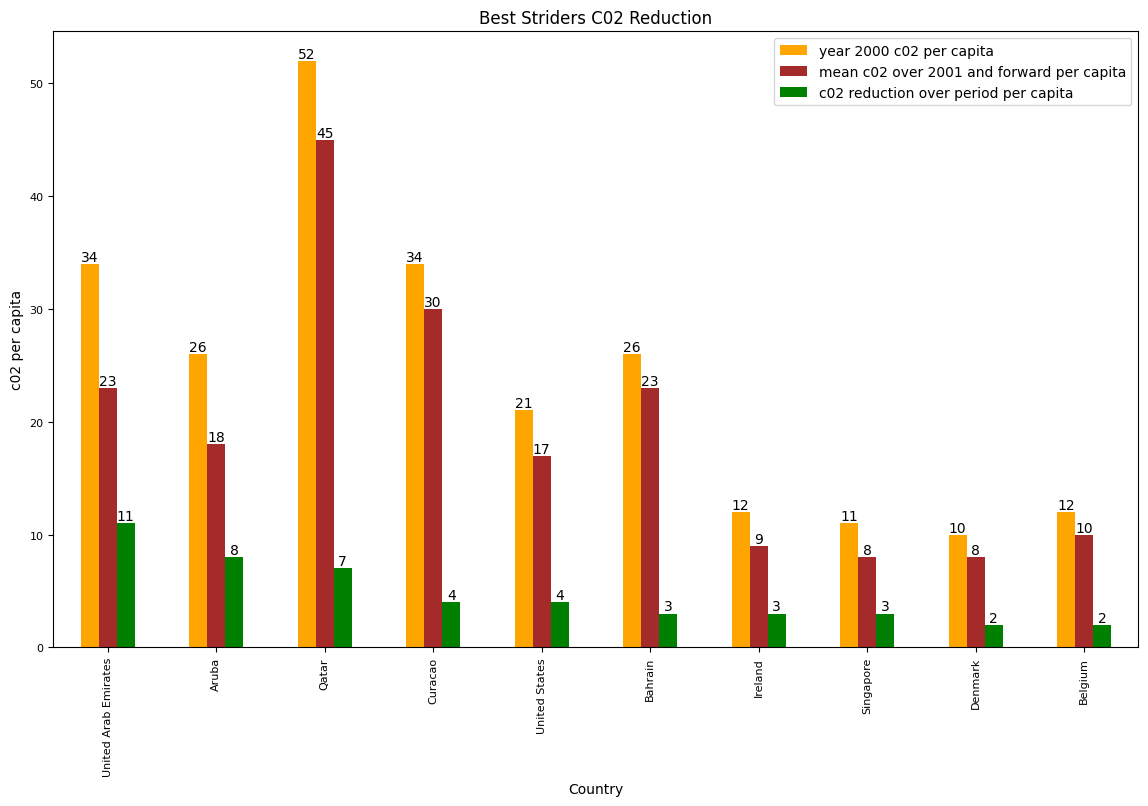

In [17]:
c02_reduction_champs_prep = pop_ann_c02_gdp_meat_vehicle_diet_prep[['Country','Year','Annual_c02_per_cap']].copy()

# exlude non countrie records
list_of_exclude_entries = [
     'Land-locked developing countries (LLDC)',
     'Least developed countries', 'Less developed regions',
     'Less developed regions, excluding China',
     'Less developed regions, excluding least developed countries',
     'Low-income countries', 'Lower-middle-income countries',
     'World','High-income countries','Upper-middle-income countries'
]

c02_reduction_champs_prep = c02_reduction_champs_prep[~c02_reduction_champs_prep['Country'].isin(list_of_exclude_entries)].copy()


c02_champs_2000_as_basis = (
    c02_reduction_champs_prep[c02_reduction_champs_prep['Year']=='01-01-2000']
    .reset_index()
    .rename(columns={'Annual_c02_per_cap':'year 2000 c02 per capita'})
    .drop(['Year','index'], axis=1)
)
c02_champs_2000_as_basis

c02_champs_mean_after_2000 = (
    c02_reduction_champs_prep[c02_reduction_champs_prep['Year']>'01-01-2000']
    .groupby('Country')['Annual_c02_per_cap'].mean()
    .reset_index()
    .rename(columns={'Annual_c02_per_cap':'mean c02 over 2001 and forward per capita'})
)

c02_champs_mean_after_2000

dataset_key = ['Country']

combine  = (
    pd.merge(c02_champs_2000_as_basis , c02_champs_mean_after_2000 , how="inner", on=dataset_key, suffixes=('', '_y'))
)

combine['c02 reduction over period per capita'] = combine['year 2000 c02 per capita'] - combine['mean c02 over 2001 and forward per capita']


ax = (combine.sort_values(by=['c02 reduction over period per capita'], ascending=False)
.head(10)
.round(0)
.set_index('Country')
.plot(kind='bar'
,stacked=False
      ,fontsize=8
      ,color=['orange', 'brown','green']
      ,figsize=(14,8)
      ,title='Best Striders C02 Reduction'
      ,ylabel='c02 per capita')
)

for heights in ax.containers:
    ax.bar_label(heights)


### Question / Answer 3:
- Q: Which non-fossil fuel energy technology will have the best price in the future?
- How: take the all on rows on World level. Plot it using x-axis Year
Onshore seems to be lowest and going lower. Solar is following up.


Answer: Using lienar regression it seems that Solar photovoltaic levelized cost of energy seems to have the best price in the feature

Solution below

In [18]:
prep_filter = cost_engy_raw[ (cost_engy_raw['Year']>2011) & (cost_engy_raw['Entity']=='World') ]

prep3 = (
    prep_filter
    .drop(['Entity','Code'], axis=1)
)

prep3.dtypes


Year                                                   int64
Bioenergy levelized cost of energy                   float64
Geothermal levelized cost of energy                  float64
Offshore wind levelized cost of energy               float64
Solar photovoltaic levelized cost of energy          float64
Concentrated solar power levelized cost of energy    float64
Hydropower levelized cost of energy                  float64
Onshore wind levelized cost of energy                float64
dtype: object

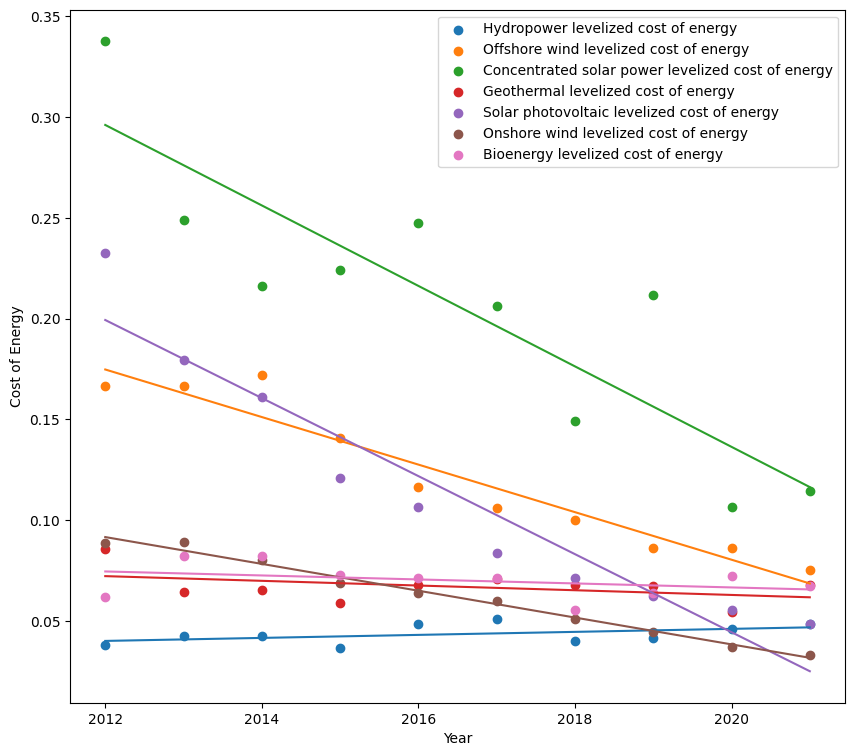

In [21]:
measure_list = {'Bioenergy levelized cost of energy',
                'Geothermal levelized cost of energy'
                ,'Offshore wind levelized cost of energy',
                'Solar photovoltaic levelized cost of energy',
                'Concentrated solar power levelized cost of energy',
                'Hydropower levelized cost of energy',
                'Onshore wind levelized cost of energy'}


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 9))

for i, measure in enumerate(measure_list):
    X = prep3[['Year']]
    Y = prep3[measure]
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    ax.scatter(X, Y, label=measure)  # Add label to each scatter plot
    ax.plot(X, Y_pred)

# Add labels to the axes
ax.set_xlabel('Year')
ax.set_ylabel('Cost of Energy')

# Add legend to the plot
ax.legend()

# Show the plot
plt.show()


